In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import os
os.chdir("..")
os.chdir("Preprocessing")
from preprocessing import *
import selfies as sf

#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\kcat_transferase.csv")
hydro = pd.read_csv("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\hydration_energy.csv")

In [22]:
#hydro energy for hydro energy data set
hydro["Kcat"] = np.log10(hydro["Kcat"])

In [18]:
d = df.copy()

d.head()

data = d

In [3]:
# data = df.copy()
# import pandas as pd
# import numpy as np

# # Sample data

# # Determine vocabulary
# all_smiles = "".join(df["Compound"].tolist())
# vocab = sorted(set(all_smiles))
# vocab_size = len(vocab)

# # Mapping from character to index and vice-versa
# char_to_index = {char: idx for idx, char in enumerate(vocab)}
# index_to_char = {idx: char for char, idx in char_to_index.items()}

# # One-hot encoding function
# def one_hot_encode(smiles_string):
#     # Tokenize the SMILES string
#     tokens = list(smiles_string)
#     # Initialize a matrix for one-hot encoding: len(tokens) x vocab_size
#     one_hot = np.zeros(vocab_size, dtype=int)
#     for token in tokens:
#         one_hot[char_to_index[token]] = 1
#     return one_hot

# # Apply one-hot encoding to each SMILES string
# encoded_data = np.stack(df["Compound"].apply(one_hot_encode).to_numpy())

# # Convert the encoded data to a DataFrame
# one_hot_df = pd.DataFrame(encoded_data, columns=vocab)

# data["Kcat"] = np.log10(data["Kcat"])  # Applying log(x + 1) to handle zeros

# # Rename columns using list comprehension as provided
# fixed_columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_').replace('#', 'hash_') for col in one_hot_df.columns]

# # Append an incrementing index to duplicate column names to make them unique
# seen = {}
# final_columns = []
# for col in fixed_columns:
#     if col in seen:
#         seen[col] += 1
#         final_columns.append(f"{col}_{seen[col]}")
#     else:
#         seen[col] = 1
#         final_columns.append(col)

# one_hot_df.columns = final_columns


In [42]:
encoded_df = pd.read_csv("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\encoded_amino.csv")


In [ ]:
# Assuming encoded_df is your one-hot encoded data from before
amino_pca = PCA(n_components=433)
principal_components = amino_pca.fit_transform(encoded_df)

# Convert to DataFrame for convenience
amino_pca_df = pd.DataFrame(data=principal_components)

In [19]:
data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit
0,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,0.0410,s^(-1)
1,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,1.0200,s^(-1)
2,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.0830,s^(-1)
3,2.1.1.10,Brassica oleracea,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,0.0375,s^(-1)
4,2.1.1.10,Escherichia coli,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,0.3800,s^(-1)


In [5]:
#preprocessing
#lets encode the data using label encoder 
label_encoder = LabelEncoder()
data["EC_number"] = label_encoder.fit_transform(data["EC_number"])
data["Species"] = label_encoder.fit_transform(data["Species"])

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_to_index = {amino: i for i, amino in enumerate(amino_acids)}

# Convert amino acid sequences to one-hot encoding
def convert_to_one_hot(sequence, max_length):
    one_hot_sequence = np.zeros((max_length, len(amino_acids)))
    
    for i, amino in enumerate(sequence):
        if amino in amino_to_index:
            index = amino_to_index[amino]
            one_hot_sequence[i, index] = 1
            
    return one_hot_sequence.flatten()

# Determine the maximum sequence length
max_sequence_length = max(len(seq) for seq in data["Amino_encoding"])

# Apply the conversion to the DataFrame column
data["Amino"] = data["Amino_encoding"].apply(lambda seq: convert_to_one_hot(seq, max_sequence_length)).tolist()

# convert compound name into numbers.
compound = data["Compound"]

data["smiles"] = [Chem.MolFromSmiles(smiles) for smiles in compound]

mol = data["smiles"]

def smiles_to_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return fingerprint
    else:
        return None

# Apply logarithmic transformation to 'Kcat'
data["Kcat"] = np.log10(data["Kcat"])  # Applying log(x + 1) to handle zeros


# add molecular weights as a feature

def molecular_weight(compound):
    mol = Chem.MolFromSmiles(compound)
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return none

data["Molecular_Weight"] = data["Compound"].apply(molecular_weight)

#apply log to molecular weight because it is not well distributed

data["Molecular_Weight"] = np.log10(data['Molecular_Weight'])


# add logP values
# Polar Surface Area
# Amino Acid features

# data.drop(columns=["Compound_name", "Amino_encoding","unit"], inplace=True)



[00:30:52] WARNING: not removing hydrogen atom without neighbors
[00:30:52] WARNING: not removing hydrogen atom without neighbors
[00:30:53] WARNING: not removing hydrogen atom without neighbors
[00:30:53] WARNING: not removing hydrogen atom without neighbors


In [23]:
hydro.head()

# data["Morgan_fingerprint"] = data["Compound"].apply(smiles_to_morgan_fingerprint)

,Unnamed: 0,Hydration_energy,Kcat
0,0,-48.6470,-1.387216
1,1,-48.6470,0.008600
2,2,-48.6470,-1.080922
3,3,-51.4321,-1.425969
4,4,-51.4321,-0.420216


In [ ]:
data_features = data.copy()

data_features.drop(columns=["Kcat", "Amino"], inplace=True)

In [43]:
hydration_energy =  hydro["Hydration_energy"]
data_hydration_energy = pd.DataFrame(hydration_energy)

In [59]:
final_df = pd.concat([data["Kcat"],data_hydration_energy, encoded_df], axis=1)

In [75]:
final_df.dropna(subset=['Hydration_energy'], inplace=True)
final_df["Kcat"] = np.log10(final_df["Kcat"]) 

In [76]:
x_final_df = final_df.drop(columns="Kcat")

,Hydration_energy,Pos_1_A,Pos_1_C,Pos_1_D,Pos_1_E,Pos_1_F,Pos_1_G,Pos_1_H,Pos_1_I,Pos_1_K,...,Pos_2511_N,Pos_2511_P,Pos_2511_Q,Pos_2511_R,Pos_2511_S,Pos_2511_T,Pos_2511_V,Pos_2511_W,Pos_2511_Y,Pos_2511_X
0,-48.6470,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-48.6470,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-48.6470,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-51.4321,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-51.4321,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [78]:
# train and split the data
# EC_number, Species, Amino, and fingerprint_rdk

from sklearn.model_selection import train_test_split

# x_features = np.array(data_features['Fingerprint_rdk'].tolist())
# # y = np.array(data["Kcat_normalized"])

# x_features = pd.DataFrame(x_features)

x = x_final_df
y = final_df["Kcat"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

count     4132.000000
mean       136.417471
std       1440.632035
min          0.000003
25%          0.140000
50%          2.000000
75%         22.450000
max      78300.000000
Name: Kcat, dtype: float64

In [79]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Check data types
print("x_train data type:", type(x_train))
print("y_train data type:", type(y_train))



x_train shape: (3305, 52732)
y_train shape: (3305,)
x_train data type: <class 'pandas.core.frame.DataFrame'>
y_train data type: <class 'numpy.ndarray'>


In [80]:
# this initialization of the regression model
rf_regressor = RandomForestRegressor()

rf_regressor.fit(x_train, y_train)

y_pred = rf_regressor.predict(x_test)

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
result = np.corrcoef(y_test, y_pred)[0,1]
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 
print('r2:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mse))
print("pearson:", result)


MAE:  0.7041895226301044
MSE:  1.070934162635781
r2: 0.5762845243166397
RMSE: 1.0348594893200627
pearson: 0.7692503698739195


In [70]:
# Feature importance
importances = rf_regressor.feature_importances_
print("Feature importances:", importances)

Feature importances: [0.14796263 0.         0.         ... 0.         0.         0.        ]


In [ ]:
from sklearn.model_selection import GridSearchCV

# helps finding the optimal hyperparameters
param_grid = {
    'n_estimators': [100,200,250],
    'max_depth': [1, 10, 20]
    # Add more hyperparameters and values
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

best_rf_regressor = grid_search.best_estimator_

In [ ]:
grid_search.score(x_train, y_train)

In [ ]:
# Create a random forest regressor

from sklearn.model_selection import learning_curve


regressor = RandomForestRegressor(random_state=42)

# Create learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    regressor, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)

plt.legend(loc="best")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_regressor.set_params(n_estimators=n)
    rf_regressor.fit(x_train, y_train)
    scores.append(rf_regressor.score(x_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

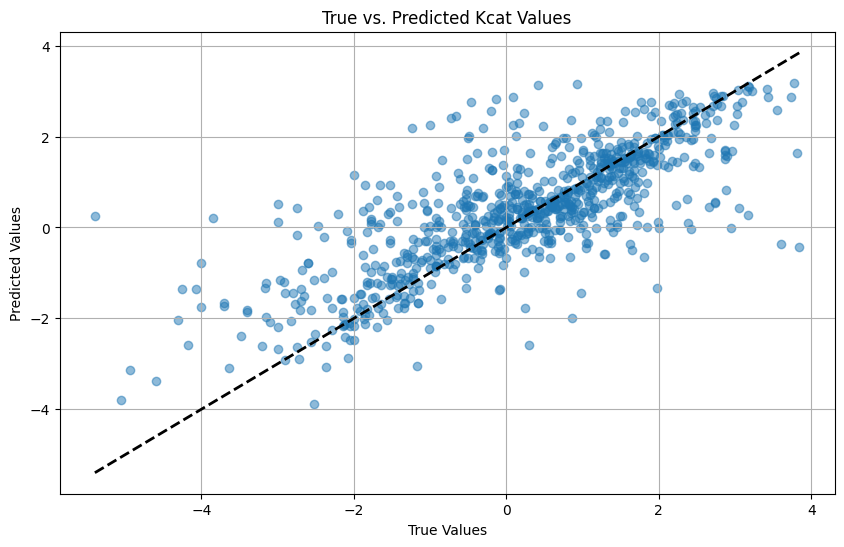

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Kcat Values')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

pearson_corr = np.corrcoef(y_pred, y_test)[0, 1]
print(f"Pearson correlation coefficient: {pearson_corr:.3f}")